# Question 1. [50 marks]
Ensemble Learning, a form of meta-learning, is a machine learning paradigm where multiple
learners are trained to solve the same problem. In this assignment, you will code up the
meta-learning algorithms Bagging (short for Bootstrap Aggregating) and Boosting.
Note: Kindly do perform the splitting of the dataset and other necessary tasks (cleaning, normalization etc.) based on prior lab experience.
Download Housing Dataset and perform the following tasks (Each task carries 5 marks) \
 \
1) Use a simple Decision Tree regressor to predict the price of a house (without any
validation) and report the accuracy. \


In [54]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 3/Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [55]:
df.dropna(inplace=True)
#df.drop(df[df['price']>8000000].index,inplace=True)
LE = preprocessing.LabelEncoder()
enc_list=['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus']
for feature in enc_list:
    df[feature]=LE.fit_transform(df[feature])

#df['area']=preprocessing.MinMaxScaler().fit_transform(pd.DataFrame(df['area']))

Y = pd.DataFrame(df['price'])
X = df.drop(['price'],axis=1)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=41)
X_train.reset_index(drop=True,inplace=True)
Y_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
Y_test.reset_index(drop=True,inplace=True)

print()
print(X_train.head())
print()
print(Y_train.head())


   area  bedrooms  bathrooms  ...  parking  prefarea  furnishingstatus
0  4800         3          1  ...        0         0                 2
1  6050         3          1  ...        0         1                 1
2  5400         5          1  ...        0         1                 0
3  5320         2          1  ...        1         1                 2
4  7000         3          1  ...        0         0                 2

[5 rows x 12 columns]

     price
0  5866000
1  5243000
2  5565000
3  3465000
4  4795000


Metrics for the DTR model on testing data :

MSE : 2126719553927.666016
RMS Error : 1458327.66
R2 score : 0.4227



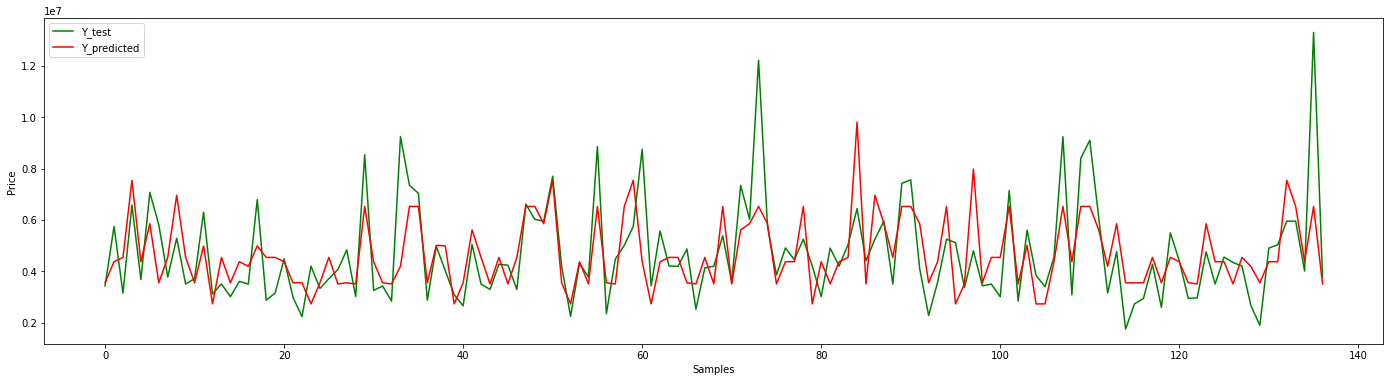

In [58]:
def create_split(dataset):
    best_split = {}
    max_var_reduction = -10000

    for fi in range(np.shape(dataset)[1]-1):
        feature_values = dataset[:, fi]
        thresholds = np.unique(feature_values)

        for th in thresholds:
            dataset_left = np.array([x for x in dataset if x[fi]<=th])
            dataset_right = np.array([x for x in dataset if x[fi]>th])

            if len(dataset_left)>0 and len(dataset_right)>0:
                y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                left_w = len(left_y) / len(y)
                right_w = len(right_y) / len(y)

                curr_var_reduction = np.var(y) - (left_w*np.var(left_y) + right_w*np.var(right_y))

                if curr_var_reduction>max_var_reduction:
                    best_split["feature_index"] = fi
                    best_split["threshold"] = th
                    best_split["dataset_left"] = dataset_left
                    best_split["dataset_right"] = dataset_right
                    best_split["var_reduction"] = curr_var_reduction
                    max_var_reduction = curr_var_reduction
                    
    return best_split

class Node():
    def __init__(self, left=None, right=None, feature_index=None, threshold=None, var_reduction=None, value=None):
        self.left = left
        self.right = right      
        self.feature_index = feature_index
        self.threshold = threshold
        self.var_reduction = var_reduction
        self.value = value

def build_decision_tree(dataset, max_depth, curr_depth=0):
    min_samples = 3
    X = dataset[:,:-1]
    Y = dataset[:,-1]        
    if np.shape(X)[0]>=min_samples and curr_depth<=max_depth:
        best_split = create_split(dataset)
        if len(best_split)>0:
            if best_split["var_reduction"]>0:
                left_subtree = build_decision_tree(best_split["dataset_left"], max_depth, curr_depth+1)
                right_subtree = build_decision_tree(best_split["dataset_right"],max_depth, curr_depth+1)
                return Node(left_subtree, right_subtree, best_split["feature_index"], best_split["threshold"], best_split["var_reduction"])
        
    leaf_value = np.mean(Y)
    return Node(value=leaf_value)

def train_model(X, Y, max_depth):
    root = None
    X = np.array(X)
    Y = np.array(Y)
    np.reshape(Y,(-1,1))
    dataset = np.concatenate((X, Y), axis=1)
    root = build_decision_tree(dataset, max_depth)
    return root

def predict(trained_model, X):
    X = np.array(X)
    preditions = []
    for x in X:
        pred = get_p(x, trained_model)
        preditions.append(pred)
    return preditions

def get_p(x, tree):
    if tree.value!=None: 
        return tree.value
    feature_val = x[tree.feature_index]
    if feature_val<=tree.threshold:
        return get_p(x, tree.left)
    else:
        return get_p(x, tree.right)

trained_model = train_model(X_train,Y_train, 3)
Y_predicted = np.array((predict(trained_model,X_test)))
Y_test = np.array(Y_test)

mse = metrics.mean_squared_error(Y_test, Y_predicted)

print('Metrics for the DTR model on testing data :\n')
print(f'MSE : {mse:2f}')
print(f'RMS Error : {np.sqrt(mse):.2f}')
print(f'R2 score : {metrics.r2_score(Y_test,Y_predicted):.4f}')
print()

plt.figure(figsize=(24,6))
plt.plot(range(len(Y_test)),Y_test,'g',label='Y_test')
plt.plot(range(len(Y_test)),Y_predicted,'r',label='Y_predicted')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.legend()
plt.show()

2) Perform 5-fold cross-validation to determine what the best max_depth would be for a single regression tree using the entire 'Xtrain' feature set. \


In [5]:
X_partitions=[pd.DataFrame() for i in range(5)]
Y_partitions=[pd.DataFrame() for i in range(5)]

X_partitions[0]=X_train
Y_partitions[0]=Y_train
for i in range(0,4):
    X_partitions[i], X_partitions[i+1],Y_partitions[i], Y_partitions[i+1] = model_selection.train_test_split(X_partitions[i], Y_partitions[i], test_size=(5-i-1)/(5-i),random_state=41)

cv_plots = []
best_cv_model = Node()
best_max_depth = 0
best_r2 = 0

for md in range(1,7):
    optimal_model = Node()
    r2_sum = 0
    r2_op = 0
    md_ypredicted = []
    md_ytest = []
    for i in range(5):
        cv_xtest = np.array(X_partitions[i])
        cv_ytest = np.array(Y_partitions[i])
        cv_xtrain = []
        cv_ytrain = []
        for j in range(5):
            if i==j:
                continue
            cv_xtrain.append(X_partitions[j])
            cv_ytrain.append(Y_partitions[j])
        cv_xtrain = pd.concat(cv_xtrain)
        cv_ytrain = pd.concat(cv_ytrain)
        
        dtr = train_model(cv_xtrain,cv_ytrain,md)
        cv_ypredicted = np.array(predict(dtr,cv_xtest))
        m={'r2_score':metrics.r2_score(cv_ytest,cv_ypredicted)}
        if 0.6>m['r2_score']>0.35 and m['r2_score']>r2_op:
            optimal_model = dtr
            r2_op = m['r2_score']
            md_ypredicted = cv_ypredicted
            md_ytest = cv_ytest
        r2_sum += m['r2_score']
    
    cv_plots.append([md,md_ytest,md_ypredicted,r2_sum/5])

    curr_r2 = r2_sum/5
    if curr_r2>best_r2:
        best_r2 = curr_r2
        best_cv_model = optimal_model
        best_max_depth = md
        
print(f'After 5-fold cross-validation and testing various max_depths,\noptimal max_depth = {best_max_depth}\nr2_score = {best_r2:.4f}\n')
cv_ypredicted = np.array(predict(best_cv_model,X_test))
r2_test = metrics.r2_score(Y_test, cv_ypredicted)
mean_abs_err_test = metrics.mean_absolute_error(Y_test, cv_ypredicted)
print('Metrics of price predictions on Testing data :')
print(f'r2_score = {r2_test:.4f}')
print(f'mean_absolute_error = {mean_abs_err_test:.2f}')

After 5-fold cross-validation and testing various max_depths,
optimal max_depth = 3
r2_score = 0.4499

Metrics of price predictions on Testing data :
r2_score = 0.4438
mean_absolute_error = 1012812.81


3) Visualize and summarize the results across the validation sets. \


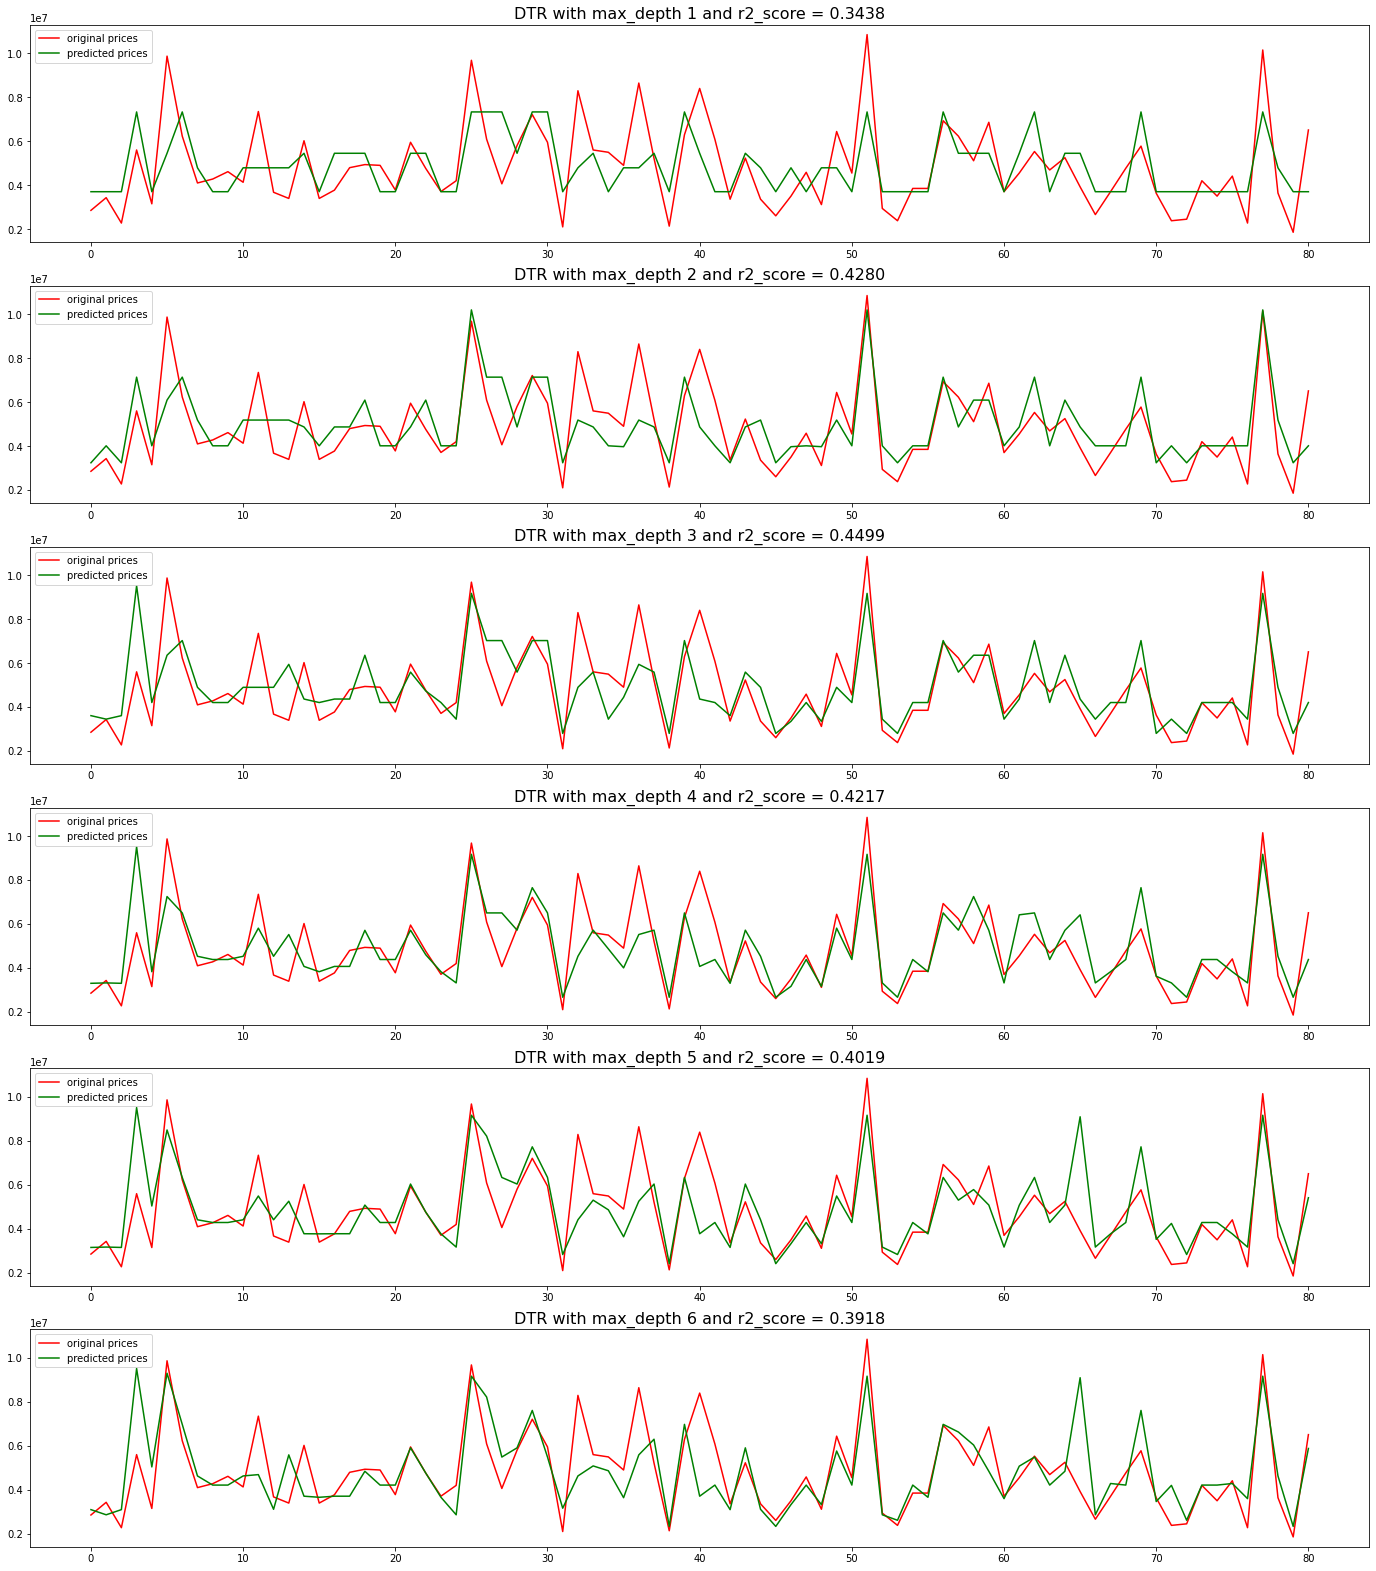

In [6]:
r2_on_md = []

plt.figure(figsize=(24,28))
for elem in cv_plots:
    r2_on_md.append(elem[3])
    plt.subplot(6,1,elem[0])
    plt.title(f'DTR with max_depth {elem[0]} and r2_score = {elem[3]:.4f}',fontsize=16)
    plt.plot(range(len(elem[1])),elem[1],'r',label='original prices')
    plt.plot(range(len(elem[1])),elem[2],'g',label='predicted prices')
    plt.legend()
plt.show()

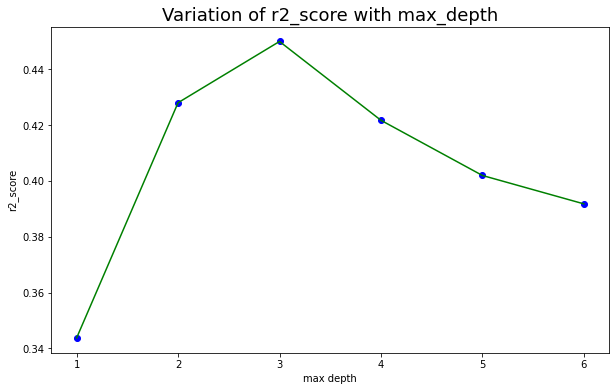

In [7]:
plt.figure(figsize=(10,6))
plt.title('Variation of r2_score with max_depth',fontsize=18)
plt.plot(range(1,7),r2_on_md,'bo')
plt.plot(range(1,7),r2_on_md,'g')
plt.xlabel('max depth')
plt.ylabel('r2_score')
plt.show()

4) Apply bagging to create different training datasets (select n_estimators = 10) \


In [8]:
def mk_bootstrap(X:pd.DataFrame, Y:pd.DataFrame, n:int):
    indices = np.random.randint(low=0,high=len(X),size=n)
    X = X.iloc[indices]
    Y = Y.iloc[indices]
    X.reset_index(drop=True,inplace=True)
    Y.reset_index(drop=True,inplace=True)
    return X,Y

def mk_model(X:pd.DataFrame, Y:pd.DataFrame, md:int):
    X,Y = mk_bootstrap(X,Y,int(len(X)))
    DTR = train_model(X,Y,md)
    return DTR


5) Train on different dataset to obtain different decision trees. \


In [9]:
def mk_DTRs(X:pd.DataFrame,Y:pd.DataFrame, n_estimators:int, md:int):
    all_DTRs = []
    for i in range(n_estimators):
        dtr = mk_model(X,Y,md)
        all_DTRs.append(dtr)
    return all_DTRs

def bagging(X:pd.DataFrame,Y:pd.DataFrame, n_estimators:int, md:int):
    all_DTRs = mk_DTRs(X,Y,n_estimators,md)
    Y_set = [np.reshape(np.array(Y),(-1,))]
    for tree in all_DTRs:
        ypreds = predict(tree, X)
        Y_set.append(np.array(ypreds))
    return [Y_set, all_DTRs]
    

6) Summarize how each of the separate trees performed (both numerically and visually) \
using R-squared score as the metric. How do they perform on average?


In [10]:
FOREST = bagging(X_train, Y_train, 10, 3)
Y_original = FOREST[0][0]
predictions = FOREST[0][1:]
all_DTRs = FOREST[1]
r2_scores = []

def R2(Y,P):
    Y = np.array(Y)
    P = np.array(P)
    rss = Y-P
    tss = Y-np.mean(Y)
    rss*=rss
    tss*=tss
    return 1-np.sum(rss)/np.sum(tss)

for pred in predictions:
    curr_r2 = R2(Y_original,pred)
    r2_scores.append(curr_r2)

print(f'\nAverage R-squared score for Forest on Training data is \n{np.mean(r2_scores):.4f}')


Average R-squared score for Forest on Training data is 
0.5542


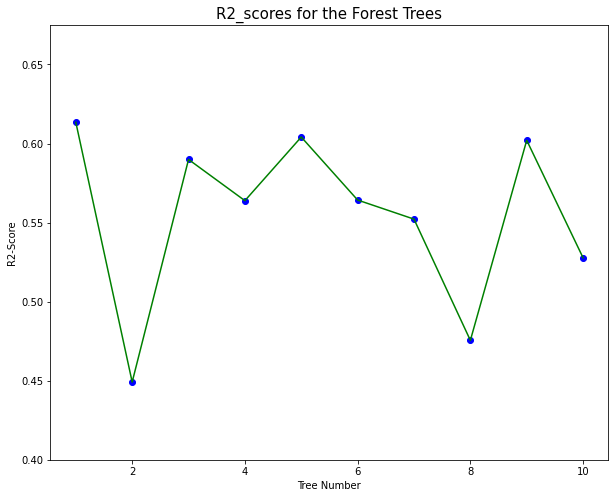

In [45]:
plt.figure(figsize=(10,8))
plt.title('R2_scores for the Forest Trees',fontsize=15)
plt.plot(range(1,11),r2_scores,'bo')
plt.plot(range(1,11),r2_scores,'g')
plt.xlabel('Tree Number')
plt.ylabel('R2-Score')
plt.ylim((0.4,0.675))
plt.show()

7) Combine the trees into one prediction and evaluate it using R-squared score.


In [12]:
ytest_preds = []
Y_test = np.reshape(Y_test,(-1,))
for tree in all_DTRs:
    ytest_preds.append(predict(tree,X_test))

r2_scores_test = []
for i in range(10):
    r2_scores_test.append(R2(Y_test,ytest_preds[i]))


weights = r2_scores_test-np.min(r2_scores_test)
weights /= np.max(weights)
Y_preds = np.zeros(shape=Y_test.shape)
for i in range(10):
    prev_pred = np.array(ytest_preds[i])
    Y_preds += prev_pred*weights[i]
Y_preds/=np.sum(weights)

print(f'\nR-squared score on Testing Data, after combining the Random Forest Tree models : \n{R2(Y_test,Y_preds):.4f}')



R-squared score on Testing Data, after combining the Random Forest Tree models : 
0.4761


8) How will the results above change if 'max_depth' is increased? What if it is decreased?


In [60]:
print('Average R-squared score for Combined Random Forest on Testing data with different max_depths :\n')

r2_scores_md = []

for md in range(1,6):
    FOREST_md = bagging(X_train, Y_train, 10, 3)
    all_DTRs = FOREST_md[1]

    ytest_preds = []
    Y_test = np.reshape(Y_test,(-1,))
    for tree in all_DTRs:
        ytest_preds.append(predict(tree,X_test))

    r2_scores_test = []
    for i in range(10):
        r2_scores_test.append(R2(Y_test,ytest_preds[i]))

    weights = r2_scores_test-np.min(r2_scores_test)
    weights /= np.max(weights)
    Y_preds = np.zeros(shape=Y_test.shape)
    for i in range(10):
        prev_pred = np.array(ytest_preds[i])
        Y_preds += prev_pred*weights[i]
    Y_preds/=np.sum(weights)
    curr_r2 = R2(Y_test,Y_preds)
    r2_scores_md.append(curr_r2)
    print(f'max depth = {md} ; r2_score = {curr_r2:.4f}')

Average R-squared score for Combined Random Forest on Testing data with different max_depths :

max depth = 1 ; r2_score = 0.5833
max depth = 2 ; r2_score = 0.5351
max depth = 3 ; r2_score = 0.5602
max depth = 4 ; r2_score = 0.5192
max depth = 5 ; r2_score = 0.5629


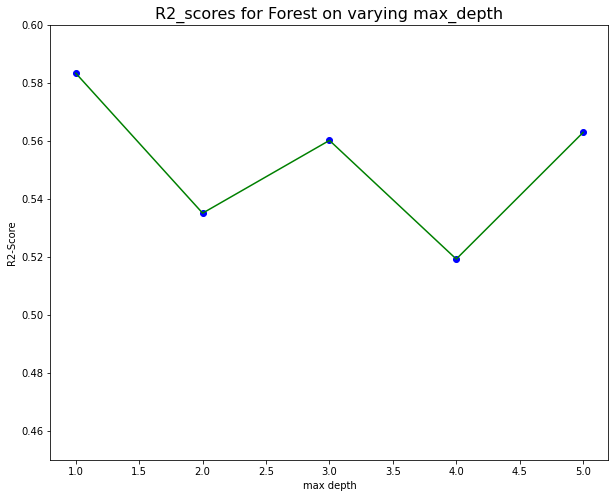

In [61]:
plt.figure(figsize=(10,8))
plt.title('R2_scores for Forest on varying max_depth',fontsize=16)
plt.plot(range(1,6),r2_scores_md,'bo')
plt.plot(range(1,6),r2_scores_md,'g')
plt.xlabel('max depth')
plt.ylabel('R2-Score')
plt.ylim((0.45,0.60))
plt.show()

9) Train random forest regressor, report mean squared error and mean absolute error.
(from sklearn.ensemble import RandomForestRegressor)


In [15]:
from sklearn.ensemble import RandomForestRegressor

sk_forest = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
Y_train = np.array(Y_train)
sk_forest.fit(X_train, np.reshape(Y_train,(-1,)))

Ypred_sk = np.reshape(sk_forest.predict(X_test),(-1,))

print('For sklearn RandomForestRegressor, metrics on Testing data are\n')
print(f'Mean Squared Error = {metrics.mean_squared_error(Ypred_sk,Y_test):.2f}')
print(f'Mean Absolute Error = {metrics.mean_absolute_error(Ypred_sk,Y_test):.2f}')
print(f'R-squared score = {metrics.r2_score(Y_test,Ypred_sk):.4f}')

For sklearn RandomForestRegressor, metrics on Testing data are

Mean Squared Error = 1964367302421.53
Mean Absolute Error = 988983.94
R-squared score = 0.4668


10) Train Adaboost regressor, report mean squared error and mean absolute error.
(from sklearn.ensemble.AdaBoostRegressor)

In [16]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(n_estimators=100, random_state=0)
ada_reg.fit(X_train, np.reshape(Y_train,(-1,)))

Ypred_ada = np.reshape(ada_reg.predict(X_test),(-1,))

print('For sklearn AdaBoostRegressor, metrics on Testing data are\n')
print(f'Mean Squared Error = {metrics.mean_squared_error(Ypred_ada,Y_test):.2f}')
print(f'Mean Absolute Error = {metrics.mean_absolute_error(Ypred_ada,Y_test):.2f}')
print(f'R-squared score = {metrics.r2_score(Y_test,Ypred_ada):.4f}')

For sklearn AdaBoostRegressor, metrics on Testing data are

Mean Squared Error = 1709461030984.37
Mean Absolute Error = 970131.22
R-squared score = 0.5360


# Question 2. [50 marks]
Boosting: - Boosting is an ensemble modeling technique which attempts to build a strong classifier from the number of weak classifiers. It is done by building a model using weak models in series. First, a model is built from the training data. Then the second model is built which tries to correct the errors present in the first model. This procedure is continued and models are added until either the complete training data set is predicted correctly or the maximum number of models are added. \
 \



In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from tqdm import tqdm

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Lab 3/Breast_cancer_data.csv')
df.dropna(inplace=True)

Y = pd.DataFrame(df['diagnosis'])
X = df.drop(['diagnosis'],axis=1)

cols = X.columns
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X))
X.columns = cols
X.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
0,0.521037,0.022658,0.545989,0.363733,0.593753
1,0.643144,0.272574,0.615783,0.501591,0.289880
2,0.601496,0.390260,0.595743,0.449417,0.514309
3,0.210090,0.360839,0.233501,0.102906,0.811321
4,0.629893,0.156578,0.630986,0.489290,0.430351


1) Use a simple Decision Tree classifier to predict the outcome (without any validation) and
report the accuracy.[5]

In [64]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=41)

X_train.reset_index(drop=True,inplace=True)
Y_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
Y_test.reset_index(drop=True,inplace=True)

def gini_index(data):
    all_classes = np.unique(data)
    gini = 0
    for class_ in all_classes:
        p_class = len(data[data == class_]) / len(data)
        gini += p_class**2
    return 1 - gini

def cont_to_cat(dataset):
    best_split = {}
    max_IG = -10
    for fi in range(np.shape(dataset)[1]-1):
        feature_values = dataset[:, fi]
        thresholds = np.unique(feature_values)

        for th in thresholds:
            dataset_left = np.array([x for x in dataset if x[fi]<=th])
            dataset_right = np.array([x for x in dataset if x[fi]>th])

            if len(dataset_left)>0 and len(dataset_right)>0:
                y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                left_w = len(left_y) / len(y)
                right_w = len(right_y) / len(y)

                curr_IG = gini_index(y) - (left_w*gini_index(left_y) + right_w*gini_index(right_y))

                if curr_IG>max_IG:
                    best_split["feature_index"] = fi
                    best_split["threshold"] = th
                    best_split["dataset_left"] = dataset_left
                    best_split["dataset_right"] = dataset_right
                    best_split["info_gain"] = curr_IG
                    max_IG = curr_IG
                    
    return best_split

class Node():
    def __init__(self, left=None, right=None, feature_index=None, threshold=None, IG=None, value=None):
        self.left = left
        self.right = right      
        self.feature_index = feature_index
        self.threshold = threshold
        self.IG = IG
        self.value = value

def build_decision_tree(dataset, max_depth, curr_depth=0):
    min_samples = 3
    X = dataset[:,:-1]
    Y = dataset[:,-1]        
    if np.shape(X)[0]>=min_samples and curr_depth<=max_depth:
        best_split = cont_to_cat(dataset)
        if best_split["info_gain"]>0:
            left_subtree = build_decision_tree(best_split["dataset_left"],max_depth, curr_depth+1)
            right_subtree = build_decision_tree(best_split["dataset_right"],max_depth, curr_depth+1)
            return Node(left_subtree, right_subtree, best_split["feature_index"], best_split["threshold"], best_split["info_gain"])

    leaf_value = max(list(Y), key=list(Y).count)
    return Node(value=leaf_value)

def train_model(X, Y, max_depth):
    root = None
    X = np.array(X)
    Y = np.array(Y)
    Y = np.reshape(Y,(-1,1))
    dataset = np.concatenate((X, Y), axis=1)
    root = build_decision_tree(dataset, max_depth)
    return root

def classify(trained_model, X):
    X = np.array(X)
    preditions = []
    for x in X:
        pred = predict(x, trained_model)
        preditions.append(pred)
    return preditions

def predict(x, tree):
    if tree.value!=None: 
        return tree.value
    feature_val = x[tree.feature_index]
    if feature_val<=tree.threshold:
        return predict(x, tree.left)
    else:
        return predict(x, tree.right)

DTC = train_model(X_train,Y_train, 3)
Y_predicted = np.array((classify(DTC,X_test)))
Y_test = np.array(Y_test)

print(f'\nOverall Accuracy for Trained Model : {metrics.accuracy_score(Y_test, Y_predicted)*100:.2f} %')



Overall Accuracy for Trained Model : 92.40 %


2) Perform 5-fold cross-validation to determine what the best max_depth would be for a single classification tree \

using the entire 'Xtrain' feature set.[5]


In [65]:
X_partitions=[pd.DataFrame() for i in range(5)]
Y_partitions=[pd.DataFrame() for i in range(5)]

X_partitions[0]=X_train
Y_partitions[0]=Y_train
for i in range(4):
    X_partitions[i], X_partitions[i+1],Y_partitions[i], Y_partitions[i+1] = model_selection.train_test_split(X_partitions[i], Y_partitions[i], test_size=(5-i-1)/(5-i),random_state=41)

cv_plots = []
best_cv_model = Node()
best_max_depth = 0
best_acc = 0

for md in tqdm(range(1,6),'Progress Bar  '):
    optimal_model = Node()
    acc_sum = 0
    acc_op = 0
    md_ypredicted = []
    md_ytest = []
    for i in range(5):
        cv_xtest = np.array(X_partitions[i])
        cv_ytest = np.array(Y_partitions[i])
        cv_xtrain = []
        cv_ytrain = []
        for j in range(5):
            if i==j:
                continue
            cv_xtrain.append(X_partitions[j])
            cv_ytrain.append(Y_partitions[j])
        cv_xtrain = pd.concat(cv_xtrain)
        cv_ytrain = pd.concat(cv_ytrain)
        dtc = train_model(cv_xtrain,cv_ytrain,md)
        cv_ypredicted = np.array(classify(dtc,cv_xtest))
        acc = metrics.accuracy_score(cv_ytest,cv_ypredicted)
        if 0.97>acc>acc_op:
            optimal_model = dtc
            acc_op = acc
            md_ypredicted = cv_ypredicted
            md_ytest = cv_ytest
        acc_sum += acc
    
    cv_plots.append(acc_op)

    curr_acc = acc_op
    if curr_acc>best_acc:
        best_acc = curr_acc
        best_cv_model = optimal_model
        best_max_depth = md
        
print(f'\nAfter 5-fold cross-validation and testing various max_depths,\noptimal max_depth = {best_max_depth}\nAccuracy = {best_acc*100:.2f} %\n')
cv_ypredicted = np.array(classify(best_cv_model,X_test))
acc_test = metrics.accuracy_score(Y_test, cv_ypredicted)
print('Metrics of Classification on Testing data :')
print(f'Accuracy = {acc_test*100:.2f}')

Progress Bar  : 100%|██████████| 5/5 [00:41<00:00,  8.31s/it]


After 5-fold cross-validation and testing various max_depths,
optimal max_depth = 3
Accuracy = 96.25 %

Metrics of Classification on Testing data :
Accuracy = 92.98


3) Visualize and summarize the results across the validation sets.[5]


Average Accuracies for Cross-Validation sets are :
max_depth = 1 ; accuracy = 88.75
max_depth = 2 ; accuracy = 95.00
max_depth = 3 ; accuracy = 96.25
max_depth = 4 ; accuracy = 88.75
max_depth = 5 ; accuracy = 96.25



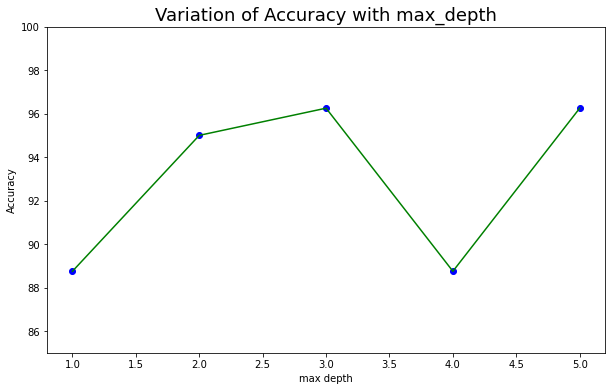

In [66]:
cv_plots = np.array(cv_plots)

print('Average Accuracies for Cross-Validation sets are :')
for i in range(5):
    print(f'max_depth = {i+1} ; accuracy = {cv_plots[i]*100:.2f}')

print()
plt.figure(figsize=(10,6))
plt.title('Variation of Accuracy with max_depth',fontsize=18)
plt.plot(range(1,6),cv_plots*100,'bo')
plt.plot(range(1,6),cv_plots*100,'g')
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.ylim(85,100)
plt.show()

4) Implement XGBoost in which subsample=0.7 and max_depth=4. [10]


In [21]:
from xgboost import XGBClassifier

model = XGBClassifier(subsample=0.7, max_depth=4)
model.fit(X_train,np.ravel(Y_train))


XGBClassifier(max_depth=4, subsample=0.7)

5) Print the accuracy on the training set and test set. [5]


In [22]:
Y_pred_train = model.predict(X_train)
Y_classified = model.predict(X_test)

print(f'\nAccuracy on Training Dataset : {metrics.accuracy_score(Y_train, Y_pred_train)*100:.2f} %')
print(f'Accuracy on Testing Dataset : {metrics.accuracy_score(Y_test, Y_classified)*100:.2f} %')


Accuracy on Training Dataset : 98.74 %
Accuracy on Testing Dataset : 95.32 %


6) Implement LightGBM with max_depth value as 3 and choose different value for
num_leaves.[7]


In [84]:
from lightgbm import LGBMClassifier

all_acc = []
best_nl = 0
best_test_acc = 0
best_train_acc = 0

for nl in range(2,15):
    model = LGBMClassifier(max_depth=3, num_leaves = nl)
    model.fit(X_train, np.ravel(Y_train))
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_acc = metrics.accuracy_score(Y_train,train_preds)
    test_acc = metrics.accuracy_score(Y_test,test_preds)
    all_acc.append([nl,train_acc*100,test_acc*100])
    if test_acc*100>=best_test_acc:
        best_test_acc = test_acc*100
        best_train_acc = train_acc*100
        best_nl = nl

print(f'We get Maximum Accuracy on testing dataset when num_leaves = {best_nl}\n')
print(f'Accuracies with num_leaves = {best_nl} :')
print(f'Training Dataset Accuracy {best_train_acc:.2f} %')
print(f'Testing Dataset Accuracy {best_test_acc:.2f} %')

We get Maximum Accuracy on testing dataset when num_leaves = 3

Accuracies with num_leaves = 3 :
Training Dataset Accuracy 95.98 %
Testing Dataset Accuracy 95.32 %


7) Analyse the relation between max_depth and num_leaves, and check for which value
the model starts overfitting?[8]


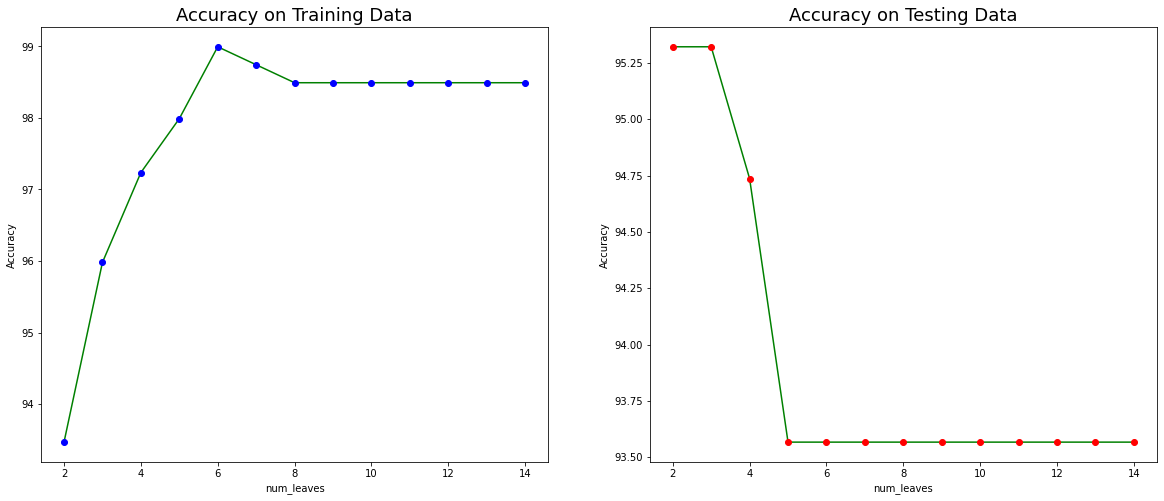

In [67]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('Accuracy on Training Data',fontsize=18)
plt.plot([x[0] for x in all_acc],[x[1] for x in all_acc],'g')
plt.plot([x[0] for x in all_acc],[x[1] for x in all_acc],'bo')
plt.xlabel('num_leaves')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.title('Accuracy on Testing Data',fontsize=18)
plt.plot([x[0] for x in all_acc],[x[2] for x in all_acc],'g')
plt.plot([x[0] for x in all_acc],[x[2] for x in all_acc],'ro')
plt.xlabel('num_leaves')
plt.ylabel('Accuracy')
plt.show()

* In the above charts, we can see that for <u>num_leaves <= 3</u>, training data classification accuracy, and testing data classification is increasing.
* But for <u>4 <= num_leaves < 8</u>, testing accuracy keeps decreasing while training accuracy is still increasing.( initial overfitting )
* For <u>8 <= num_leaves</u>, testing accuracy is minimum even though training accuracy is pretty good. ( complete overfitting )

\
 
> Hence we conclude that for <u>num_leaves >= 2^(max_depth)</u> , model shows complete overfitting. \
> So we should usually chose <u>**num_leaves < 2^(max_depth)**</u>.

8) Report which parameters can be used for better accuracy and also which parameter can
be used for avoiding overfitting.[5]

* We should control the leaf-wise tree growth for getting better accuracy on testing dataset.
* The most important parameters for tuning a LightGBM are :    
    1. max_depth : \
        We can control the max depth of the tree explicltly. \
        If we use a greater max_depth, we can overfit the tree, whereas if we keep it too low, we can underfit and have high bias. So optimum max_depth is chosen which is not too low nor too high value. \

    2. num_leaves : \
        We should choose a value which is sufficiently less than 2^(max_depth) for num_leaves. For greater values, it will lead to overfitting as the tree grows complex. \

    3. min_data_in_leaf : \
        Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. 
